# How to Render a Metal Design into GDS

For convenience, let's begin by enabling [automatic reloading of modules](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) when they change.

In [1]:
%load_ext autoreload
%autoreload 2

# Import Qiskit Metal

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross

In [3]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

In [4]:
design.overwrite_enabled = True
design.delete_all_components() 
gui.rebuild() # refresh

In [5]:
Headings.h1('Populate QDesign to demonstrate exporting to GDS format.')

In [6]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket

# Allow running the same cell here multiple times to overwrite changes.
design.overwrite_enabled = True

## Custom options for all the transmons.
options = dict(
    # Some options we want to modify from the defaults.
    # (see below for defaults)
    pad_gap = '80 um',
    pad_width = '425 um', 
    pocket_height = '650um',
    # Adding 4 connectors (see below for defaults)
    connection_pads=dict( 
        a = dict(loc_W=+1,loc_H=+1), 
        b = dict(loc_W=-1,loc_H=+1, pad_height='30um'),
        c = dict(loc_W=+1,loc_H=-1, pad_width='200um'),
        d = dict(loc_W=-1,loc_H=-1, pad_height='50um')
    )
)

# Note repeated from "QRenderer Introduction":  
The cell name denoted by, "gds_cell_name" will be the selected cell   
from design.renderers.gds.options['path_filename']   
when design.renderers.gds.export_to_gds() is executed.

In [7]:
## Create 4 TransmonPockets

# For variety and demonstartion, use different gds_cell_names.
q1 = TransmonPocket(design, 'Q1', options = dict(
    pos_x='+2.55mm', pos_y='+0.0mm', gds_cell_name='FakeJunction_02', **options))
q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x='+0.0mm', pos_y='-0.9mm', orientation = '90', gds_cell_name='FakeJunction_01', **options))
q3 = TransmonPocket(design, 'Q3', options = dict(
    pos_x='-2.55mm', pos_y='+0.0mm', gds_cell_name='FakeJunction_01',**options))
q4 = TransmonPocket(design, 'Q4', options = dict(
    pos_x='+0.0mm', pos_y='+0.9mm', orientation = '90', gds_cell_name='my_other_junction', **options))

## Rebuild the design
gui.rebuild()
gui.autoscale()

## Connecting QPins with coplanar waveguides (CPWs) as described in earlier notebooks.

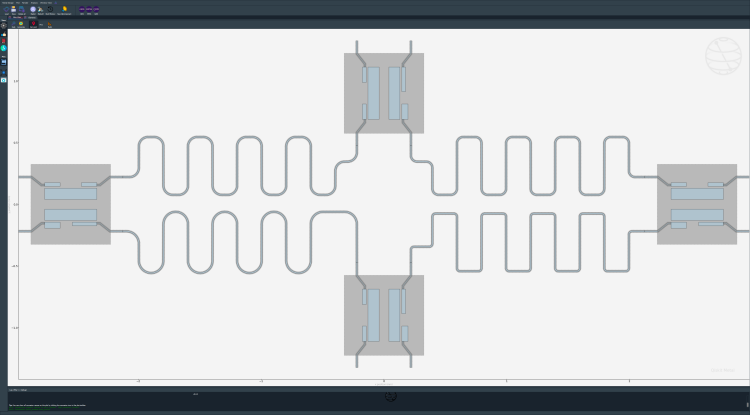

In [8]:
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
RouteMeander.get_template_options(design)

options = Dict(
    meander=Dict(
        lead_start='0.1mm',
        lead_end='0.1mm',
        asymmetry='0 um')
)


def connect(component_name: str, component1: str, pin1: str, component2: str, pin2: str,
            length: str, asymmetry='0 um', flip=False, fillet='50um'):
    """Connect two pins with a CPW."""
    myoptions = Dict(
        fillet=fillet,
        pin_inputs=Dict(
            start_pin=Dict(
                component=component1,
                pin=pin1),
            end_pin=Dict(
                component=component2,
                pin=pin2)),
        lead=Dict(
            start_straight='0.13mm',
            end_straight='0.13mm'
        ),
        total_length=length)
    myoptions.update(options)
    myoptions.meander.asymmetry = asymmetry
    myoptions.meander.lead_direction_inverted = 'true' if flip else 'false'
    return RouteMeander(design, component_name, myoptions)


asym = 90

# For variety in output, use different fillet values.
cpw1 = connect('cpw1', 'Q1', 'd', 'Q2', 'c', '5.7 mm', f'+{asym}um', fillet='25um')
cpw2 = connect('cpw2', 'Q3', 'c', 'Q2', 'a', '5.4 mm', f'-{asym}um', flip=True, fillet='100um')
cpw3 = connect('cpw3', 'Q3', 'a', 'Q4', 'b', '5.3 mm', f'+{asym}um', fillet='75um')
cpw4 = connect('cpw4', 'Q1', 'b', 'Q4', 'd', '5.5 mm', f'-{asym}um', flip=True)

gui.rebuild()
gui.autoscale()
gui.screenshot()


In [9]:
Headings.h1('Exporting to a GDS file.')

In [10]:
#QDesign registers GDS renderer during init of QDesign.
a_gds = design.renderers.gds
# An alternate way to invoke gds commands without using a_gds:
# design.renderers.gds.export_to_gds()

#Show the options for GDS
a_gds.options

{'short_segments_to_not_fillet': 'True',
 'check_short_segments_by_scaling_fillet': '2.0',
 'gds_unit': 0.001,
 'ground_plane': 'True',
 'negative_mask': {'main': []},
 'corners': 'circular bend',
 'tolerance': '0.00001',
 'precision': '0.000000001',
 'width_LineString': '10um',
 'path_filename': '../resources/Fake_Junctions.GDS',
 'junction_pad_overlap': '5um',
 'max_points': '199',
 'cheese': {'datatype': '100',
  'shape': '0',
  'cheese_0_x': '25um',
  'cheese_0_y': '25um',
  'cheese_1_radius': '100um',
  'view_in_file': {'main': {1: True}},
  'delta_x': '100um',
  'delta_y': '100um',
  'edge_nocheese': '200um'},
 'no_cheese': {'datatype': '99',
  'buffer': '25um',
  'cap_style': '2',
  'join_style': '2',
  'view_in_file': {'main': {1: True}}},
 'bounding_box_scale_x': '1.2',
 'bounding_box_scale_y': '1.2'}

###  To make `junction table` work correctly, GDS Renderer needs a correct path to a gds file, which has cells.  
Each cell is a junction, to be placed, in a Transmon.  A sample gds file is provided in directory `qiskit_metal/tutorials/resources`.
There are three cells with names "Fake_Junction_01", "Fake_Junction_01", and "my_other_junction".
The default name used by GDS Render is "my_other_junction".  If you want to customize and select a junction, through the QComponent's options, you can pass it when a qcomponent is being added to QDesign. 

In [11]:
a_gds.options['path_filename'] = '../../resources/Fake_Junctions.GDS'

Do you want GDS Renderer to fix any short-segments in your QDesign when using fillet?'



In [12]:
#If you have a fillet_value and there are LineSegments that are shorter than 2*fillet_value, 
#When true, the short segments will not be fillet'd. 
a_gds.options['short_segments_to_not_fillet'] = 'False'



In [13]:
scale_fillet = 2.0
a_gds.options['check_short_segments_by_scaling_fillet'] = scale_fillet

### What criteria will be used for identifying a short segment?
If a segment is smaller than (fillet length *  scale_fillet)

### What if a segment of LineString has few short segments?  
If option 'short_segments_to_not_fillet' == 'True', QGDSRenderer will
break the LineString into shorter Linestrings to make smaller LineStrings that will be 
either fillet'd or not, based on if the segment is short.

In [14]:
#If you want to have the short segments not be fillet'd.
a_gds.options['short_segments_to_not_fillet'] = 'True'


In [15]:
# Export to a GDS formatted file for all components in design.
#def export_to_gds(self, file_name: str, highlight_qcomponents: list = []) -> int:


# Please change the path where you want to write a GDS file.
#Examples below.  
#a_gds.export_to_gds("../../../gds-files/GDS QRenderer Notebook.gds")

a_gds.export_to_gds('GDS QRenderer Notebook.gds')



1

In [16]:
# Export a GDS file which contains only few components.

# You will probably want to put the exported file in a specific directory.  
# Please give the full path for output. 
a_gds.export_to_gds("four_qcomponents.gds",
                           highlight_qcomponents=['cpw1', 'cpw4', 'Q1', 'Q3'])



1

In [17]:
# Export a GDS file using explicit path and cpw1.name vs typing string.
# You will probably want to put the exported file in a specific directory.  
# Please give the full path for output. 
a_gds.export_to_gds("four_same_qcomponents.gds",
                           highlight_qcomponents=[cpw1.name, 'cpw4', q1.name, 'Q3'])

1

In [18]:
Headings.h1('QUESTION:  Where is the geometry of a QComponent placed?')

# Answer:  QGeometry tables!

This is better explained in folder "2 Front End User/2.4 QRenderer Introduction" in notebook, "QRenderer Introduction ".

In [18]:
Headings.h1('What does GDS do with "junction" table?')

The junction table is handled differently by each QRenderer.

GDS QRenderer gets a cell, with the name, equal to "gds_cell_name" and places the cell into the QDesign before exporting the entire QDesign to GDS. In file: `a_gds.options['path_filename'] = '../../resources/Fake_Junctions.GDS'`, the gds_cell_name is searched.  The cell is placed into QDesign using LINESTRING and width information.

The cell within "path_filename", should be "x-axis" aligned and then GDS rotates based on LineString.  The LineString should be two vertexes and it denotes two things.
1. The midpoint of segment is the center of cell. 
2. The angle made by (second tuple - fist tuple), for delta y/ delta x, is used to rotate the cell. 

When the cell from default_options.path_filename does not fit the width of LineString,
- QGDSRender will create two pads and add to cell, which is denoted in junction table, to fill the width of LineString. The length of the additional pads is the value of "width" from the junction table. 
- The option `a_gds.options["junction_pad_overlap"]='5um'` is the amount the new pads will overlap the cell. The final width of the cell plus two pads is equal to the magnitude of LineString. 

In [19]:
# View every entry in junction table.
design.qgeometry.tables['junction']

,component,name,geometry,layer,subtract,helper,chip,width,hfss_inductance,hfss_capacitance,hfss_resistance,hfss_mesh_kw_jj,q3d_inductance,q3d_capacitance,q3d_resistance,q3d_mesh_kw_jj,gds_cell_name
0,1,rect_jj,"LINESTRING (2.55000 -0.04000, 2.55000 0.04000)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,FakeJunction_02
1,2,rect_jj,"LINESTRING (0.04000 -0.90000, -0.04000 -0.90000)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,FakeJunction_01
2,3,rect_jj,"LINESTRING (-2.55000 -0.04000, -2.55000 0.04000)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,FakeJunction_01
3,4,rect_jj,"LINESTRING (0.04000 0.90000, -0.04000 0.90000)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,my_other_junction


In [20]:
# View the juction table for component "q1". 

q1.qgeometry_table('junction')

,component,name,geometry,layer,subtract,helper,chip,width,hfss_inductance,hfss_capacitance,hfss_resistance,hfss_mesh_kw_jj,q3d_inductance,q3d_capacitance,q3d_resistance,q3d_mesh_kw_jj,gds_cell_name
0,1,rect_jj,"LINESTRING (2.55000 -0.04000, 2.55000 0.04000)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,FakeJunction_02


### Geometric boundary of a QComponent?
How to obtain the boundary box of the geometry, for example: `q1.qgeometry_bounds()`.  
Explained in in folder "2 Front End User/2.4 QRenderer Introduction" in notebook, "QRenderer Introduction ".

In [21]:
#The current value of all the options for GDS QRenderer.
a_gds.options

{'short_segments_to_not_fillet': 'True',
 'check_short_segments_by_scaling_fillet': 2.0,
 'gds_unit': 0.001,
 'ground_plane': 'True',
 'negative_mask': {'main': []},
 'corners': 'circular bend',
 'tolerance': '0.00001',
 'precision': '0.000000001',
 'width_LineString': '10um',
 'path_filename': '../../resources/Fake_Junctions.GDS',
 'junction_pad_overlap': '5um',
 'max_points': '199',
 'cheese': {'datatype': '100',
  'shape': '0',
  'cheese_0_x': '25um',
  'cheese_0_y': '25um',
  'cheese_1_radius': '100um',
  'view_in_file': {'main': {1: True}},
  'delta_x': '100um',
  'delta_y': '100um',
  'edge_nocheese': '200um'},
 'no_cheese': {'datatype': '99',
  'buffer': '25um',
  'cap_style': '2',
  'join_style': '2',
  'view_in_file': {'main': {1: True}}},
 'bounding_box_scale_x': '1.2',
 'bounding_box_scale_y': '1.2'}

### Number of vertices for linestrings.
The option max_points has default of 199.  You can set it to a number no higher than 8191.

In [22]:
### For demo, set max_points to 8191 and look at the GDS output.
a_gds.options['max_points'] = '8191'
a_gds.export_to_gds('GDS QRenderer Notebook maxpoints8191.gds')

1

### Changing options 'precision' vs 'tolerance' ratio can impact how fillet will look.

The below numbers are used to create a gdspy.FlexPath when 
there is a fillet value in QGeometry table.

bend_radius – Bend radii for each path when corners is ‘circular bend’. 
It has no effect for other corner types.  QGDSRender uses 'circular bend' as a default for corners.
The fillet value used here.

Ensure that tolerance > precision.

tolerance (number) – Tolerance used to draw the paths and calculate joins.

precision (number) – Precision for rounding the coordinates of vertices when fracturing the final polygonal boundary.


In [23]:
# Restore previous example.
a_gds.options['max_points'] = '199'

# For Demo, change tolerance value.
a_gds.options['tolerance'] = '0.01'
# This exported file will not look as desired.
a_gds.export_to_gds('GDS QRenderer Notebook change tolerance.gds')


1

In [24]:
#change it back to was it was.
a_gds.options['tolerance'] = '0.00001'

### Changing Cheesing options
There are two dicts in default_options for cheesing.  One for selecting the no_cheese (keep-out region) for cheesing, the other for cheesing.  Use them to determine if you would like the cheesing cell and the no_cheese cell to be added to the GDS file.

To create the no-cheese region, we take the existing components and add a buffer around the perimeter.  The size of the buffer is an option.  

The output of the cells can be placed with a data type.  The user can select a different data type for both the no-cheese region and the cheese region.

Regarding the cheese option, there is room for expansion, presently, the shape that available for a hole is a shape=0, which is a square.  

The present placement of holes allows the user to apply edge_nocheese to the perimeter of the chip.  This allows the user to place holes at a perimeter smaller than the chip size.   Then a grid of holes is made using delta_x and delta_y. 


In [25]:
a_gds.options.no_cheese

{'datatype': '99',
 'buffer': '25um',
 'cap_style': '2',
 'join_style': '2',
 'view_in_file': {'main': {1: True}}}

In [26]:
a_gds.options.cheese

{'datatype': '100',
 'shape': '0',
 'cheese_0_x': '25um',
 'cheese_0_y': '25um',
 'cheese_1_radius': '100um',
 'view_in_file': {'main': {1: True}},
 'delta_x': '100um',
 'delta_y': '100um',
 'edge_nocheese': '200um'}

There is a dict option called view_in_file that denotes if the cells are added to GDS file.  The first sub-option is the chip name, the second sub-option is layer number, the third sub-option is  bool True/False. 

In our example, the chip is 'main' and the layer is 1.  We allow for expansion for multiple chips, and multiple ground layers. 


In [27]:
a_gds.options['cheese']['view_in_file']['main'][1] = True
a_gds.options['no_cheese']['view_in_file']['main'][1] = True
a_gds.export_to_gds("GDS QRender_cheese_keepout.gds")

1

In [28]:
a_gds.options['cheese']['view_in_file']['main'][1] = True
a_gds.options['no_cheese']['view_in_file']['main'][1] = False
a_gds.export_to_gds("GDS QRender_cheese_only.gds")

1

### Negative Mask
The GDS Renderers will, by default, create a positive mask.  If user wants a negative mask.  The user MUST identify each chip and layer which should be a negative mask. The user is allowed to mix the output per chip, per layer.  For example, one chip can have positive mask on one layer, and negative on a different layer.  This feature was implemented for, potential use, for "flip-chip".

In [29]:
#For example, just move the cpw layer to 14. 
cpw1.options.layer = 14
cpw2.options.layer = 14
cpw3.options.layer = 14
cpw4.options.layer = 14


In [30]:
gui.rebuild()

# Get a list of all the qcomponents in QDesign and then zoom on them.
all_component_names = design.components.keys()
gui.zoom_on_components(all_component_names)

In [31]:
# Turn on/off keep-out and cheesing.
a_gds.options['cheese']['view_in_file']['main'][1] = True
a_gds.options['no_cheese']['view_in_file']['main'][1] = True
a_gds.options['cheese']['view_in_file']['main'][14] = True
a_gds.options['no_cheese']['view_in_file']['main'][14] = True

# Export GDS file with negative masks for layers 1 and 14.
a_gds.options['negative_mask'] = Dict(main=[1, 14])
a_gds.export_to_gds('GDS QRenderer Notebook_neg_mask_for_layer_1_14.gds')

1

In [32]:
# Export GDS files with positive mask for layer 1 and negative mask for layer 14. 
a_gds.options['negative_mask'] = Dict(main=[14])
a_gds.export_to_gds('GDS QRenderer Notebook_neg_mask_for_layer_14.gds')

1

#  Qiskit Metal Version

In [33]:
metal.about();


Qiskit Metal        0.0.3

Basic
____________________________________
 Python              3.7.8 | packaged by conda-forge | (default, Nov 27 2020, 18:48:03) [MSC v.1916 64 bit (AMD64)]
 Platform            Windows AMD64
 Installation path   c:\workspace\qiskit-metal\qiskit_metal

Packages
____________________________________
 Numpy               1.19.5

Rendering
____________________________________
 Matplotlib          3.3.4

GUI
____________________________________
 PySide2 version        5.13.2
 Qt version          5.9.7
 SIP version         4.19.8

IBM Quantum Team


In [34]:
# If you would like, close the gui 
gui.main_window.close()

True